In [30]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Generate noise points

# Parameters
N = 100  # number of points
half_n = N // 2  # half the number 
r = 10  # Radius
x0_gt, y0_gt = 2, 3  # Ground truth center 

# genrate noisy circle points
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)  # Angle
n = s * np.random.randn(half_n)  # Noise
x = x0_gt + (r + n) * np.cos(t)  
y = y0_gt + (r + n) * np.sin(t)  
X_circ = np.column_stack((x, y))  

# creating noisy line points
s = 1.0
m, b = -1, 2  
x = np.linspace(-12, 12, half_n)  
y = m * x + b + s * np.random.randn(half_n)  
X_line = np.column_stack((x, y))  

# conbine all the points
X = np.vstack((X_circ, X_line))  




RANSAC for line

In [31]:
N = X.shape[0]  # Number of points

# total least squares error for  line
def line_total_error(x, line_indices):
    a, b, d = x[0], x[1], x[2]  
    return np.sum(np.square(a * X[line_indices, 0] + b * X[line_indices, 1] - d))

# constrain for the unit normal to the line
def cons(x):
    return x[0] ** 2 + x[1] ** 2 - 1

constraint = {'type': 'eq', 'fun': cons}

# finding the consensus set based on a threshold
def line_consensus_set(X, x, line_threshold):
    a, b, d = x[0], x[1], x[2]
    error = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    return error < line_threshold

# RANSAC parameters
line_max_iterations = 100
line_threshold = 1.0  
line_data_points = int(0.4 * N)  # Minimum number of points in consensus
line_best_error = np.inf
line_sample_size = 2  

#  best model variables
best_line_indices = []
best_line_model = []
line_inliers = []
best_line_inliers = []
line_iteration = 0

while line_iteration < line_max_iterations:
    line_indices = np.random.randint(0, N, line_sample_size)  
    x0 = np.array([1, 1, 0])  # Initial guess
    res = minimize(line_total_error, x0=x0, args=(line_indices), tol=1e-6, constraints=constraint)  # Minimize error
    line_inliers = line_consensus_set(X, res.x, line_threshold)  

    if np.sum(line_inliers) > line_data_points:
        x0 = res.x
        res = minimize(line_total_error, x0=x0, args=(line_inliers), tol=1e-6, constraints=constraint)  
        if res.fun < line_best_error:
            line_best_error = res.fun
            best_line_indices = line_indices
            best_line_model = res.x
            best_line_inliers = line_inliers


    line_iteration += 1



RANSAC for a circle

In [32]:
line_outliers = np.where(best_line_inliers == False)[0]
remnants = X[line_outliers]  # Points not included in the line consensus

#total least squares error for a circle
def circle_tls(x, indices):
    x0, y0, r = x  # Circle parameters
    x1, y1 = remnants[indices].T  # Points used for fitting
    return np.sum((np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r)**2)

#find consensus set for circle based on a threshold
def circle_consensus_set(remnants, x, circle_threshold):
    distances = np.abs(np.linalg.norm(remnants - x[:2], axis=1) - x[2])
    return distances < circle_threshold

# RANSAC parameters for circle fitting
circle_threshold = 1.0
max_circle_iterations = 100
circle_best_model = []
circle_best_inliers = []
circle_best_error = np.inf
circle_best_indices = []
circle_iteration = 0
circle_sample_size = 3
circle_num_data = 35

while circle_iteration < max_circle_iterations:
    circle_indices = np.random.randint(0, len(remnants), circle_sample_size)
    x0 = np.array([0, 0, 0])  # Initial guess
    res = minimize(circle_tls, x0, args=circle_indices, tol=1e-6)  #  error minimization
    circle_inliers = circle_consensus_set(remnants, res.x, circle_threshold)  

    if np.sum(circle_inliers) > circle_num_data:
        x0 = res.x
        res = minimize(circle_tls, x0=x0, args=(circle_inliers), tol=1e-6)  
        if res.fun < circle_best_error:
            circle_best_error = res.fun
            circle_best_indices = circle_indices
            circle_best_model = res.x
            circle_best_inliers = circle_inliers

    circle_iteration += 1



Plotting the results

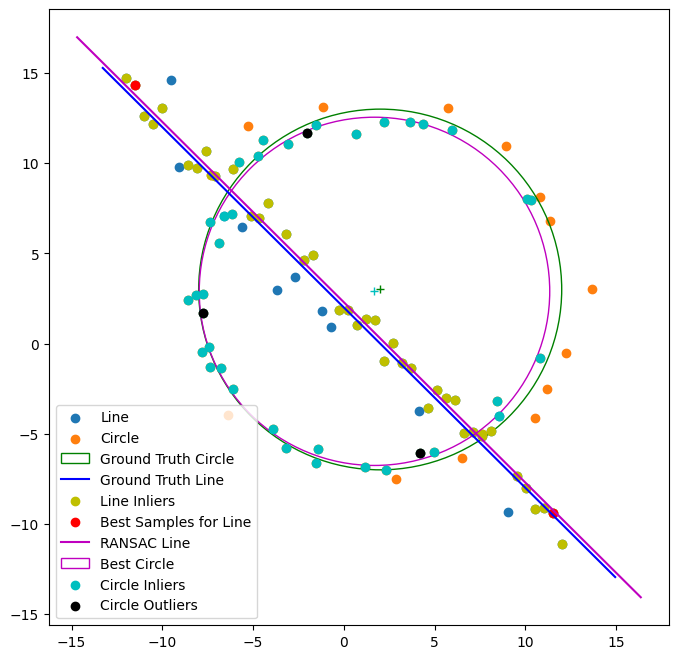

In [33]:
# Plot the noisy point set
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

# Ground truth line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='b', label='Ground Truth Line')
plt.legend()

# best fitting line and inliers
ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], color='y', label='Line Inliers')
ax.scatter(X[best_line_indices, 0], X[best_line_indices, 1], color='r', label='Best Samples for Line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_line_model[1] * x_ + best_line_model[2]) / best_line_model[1]
plt.plot(x_, y_, color='m', label='RANSAC Line')
ax.legend()

# best fitting circle and inliers
circle_best = plt.Circle((circle_best_model[0], circle_best_model[1]), circle_best_model[2], color='m', fill=False, label='Best Circle')
ax.add_patch(circle_best)
ax.plot(circle_best_model[0], circle_best_model[1], '+', color='c')
ax.scatter(remnants[circle_best_inliers, 0], remnants[circle_best_inliers, 1], color='c', label='Circle Inliers')
ax.scatter(remnants[circle_best_indices, 0], remnants[circle_best_indices, 1], color='k', label='Circle Outliers')
plt.legend()

